In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split

sns.set_style("darkgrid")

In [2]:
def RMSE(y_hat: pl.Series, y_obs: pl.DataFrame) -> float:
    return (((y_hat - y_obs.to_series()) ** 2).sum() / y_obs.shape[0]) ** 0.5

def R2(y_pred: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_pred - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def Q2(y_hat: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_hat - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

# Import niestandaryzowanego zestawu danych dane_leki.xlsx

In [3]:
input_matrix = pl.read_excel(source="dane_leki.xlsx", engine="openpyxl")

In [4]:
input_matrix.head()

Nazwa,logK HSA,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA,Zbiór
str,f64,f64,i64,i64,i64,str
"""acetaminophen""",-0.79,-0.63,2,0,2,"""t"""
"""acetylsalicylic acid""",-0.23,1.22,1,0,4,"""t"""
"""bromazepam""",0.38,0.57,1,0,3,"""t"""
"""carbamazepine""",0.69,0.68,0,0,3,"""t"""
"""chlorpromazine""",1.18,1.5,0,0,2,"""t"""


# Standaryzacja danych

In [5]:
standarized_matrix = input_matrix.select((pl.nth(range(2,6)) - pl.nth(range(2,6)).mean())/pl.nth(range(2,6)).std())

In [6]:
standarized_matrix.head()

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,f64,f64,f64
-1.64041,0.588549,-0.733122,-0.944095
0.755452,-0.205992,-0.733122,0.096336
-0.086337,-0.205992,-0.733122,-0.42388
0.056119,-1.000533,-0.733122,-0.42388
1.118069,-1.000533,-0.733122,-0.944095


In [7]:
Y_obs = input_matrix.select(pl.nth(1))

In [8]:
Y_obs.head()

logK HSA
f64
-0.79
-0.23
0.38
0.69
1.18


# Analiza PCA

In [9]:
standarized_matrix.corr()

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,f64,f64,f64
1.0,-0.633481,0.446144,-0.135951
-0.633481,1.0,-0.291248,0.290864
0.446144,-0.291248,1.0,0.326375
-0.135951,0.290864,0.326375,1.0


In [10]:
pca_model = PCA(n_components=4)

In [11]:
pca_model.fit(standarized_matrix)

PCA(n_components=4)

Wartości własne

In [12]:
pca_model.explained_variance_

array([1.94105654, 1.32253015, 0.39655623, 0.33985709])

Wektory własne

In [13]:
pca_model.components_

array([[ 0.64125435, -0.60938351,  0.44918661, -0.12520381],
       [-0.01650435,  0.23609553,  0.56431153,  0.79091024],
       [-0.15995051,  0.43573158,  0.65251792, -0.59897763],
       [ 0.75029081,  0.61890923, -0.23238815, -0.00328649]])

Główne składowe

In [14]:
PC = pl.DataFrame(
    pca_model.fit_transform(standarized_matrix),
    schema=[f"PC{i+1}" for i in range(pca_model.n_components_)],
)

In [15]:
PC.head()

PC1,PC2,PC3,PC4
f64,f64,f64,f64
-1.621676,-0.994376,0.60595,-0.693055
0.268595,-0.398618,-0.746671,0.60937
-0.206073,-0.796169,-0.300428,-0.020507
0.369458,-0.986107,-0.669421,-0.405371
1.11557,-1.415078,-0.527683,0.393109


# Podział na zbiór uczący i walidacyjny
66:33

random_state = 42

In [16]:
X_training, X_validation, Y_training, Y_validation = train_test_split(
    PC, Y_obs, test_size=0.33, random_state=42
)

In [17]:
X_training.shape

(18, 4)

In [18]:
Y_training.shape

(18, 1)

# Metoda walidacji krzyżowej KFold
n_splits = 10

shuffle = True

random_state = 0

In [19]:
KFold_model = KFold(n_splits=10, shuffle=True, random_state=0)

In [20]:
def RMSE_cv(validation_sets, X_training, Y_training) -> pl.Float64:
    residues = pl.Series(dtype=pl.Float64)

    for validation_set in validation_sets:
        x = (
            X_training.with_row_index()
            .filter(~pl.col("index").is_in(validation_set))
            .drop(pl.col("index"))
        )

        y = (
            Y_training.with_row_index()
            .filter(~pl.col("index").is_in(validation_set))
            .drop(pl.col("index"))
        )

        PCR_model = LinearRegression().fit(X=x, y=y)

        prediction = PCR_model.predict(
            X_training.with_row_index()
            .filter(pl.col("index").is_in(validation_set))
            .drop(pl.col("index"))
        )

        references = (
            Y_training.with_row_index()
            .filter(pl.col("index").is_in(validation_set))
            .drop(pl.col("index"))
        )

        residues.append(pl.Series((prediction - references).flatten()))

    return np.sqrt((residues**2).sum())

In [21]:
def RMSE_c(X_training, Y_training) -> pl.Float64 | float:

    PCR_model = LinearRegression().fit(X_training, Y_training)

    return RMSE(
        PCR_model.predict(X_training).flatten(),
        Y_training
    )

# Wykres zależności $RMSE_c$ i $RMSE_{cv}$ od liczby uwzględnianych głównych składowych

In [22]:
def principal_component_plot(n: int):
    CV_results = []
    cal_results = []
    for order in range(1, n+1):
        pca_model = PCA(n_components=order)

        PC = pl.DataFrame(
            pca_model.fit_transform(standarized_matrix),
            schema=[f"PC{i+1}" for i in range(pca_model.n_components_)],
        )

        KFold_model = KFold(n_splits=10, shuffle=True, random_state=0)

        X_training, _, Y_training, _ = train_test_split(
            PC, Y_obs, test_size=0.33, random_state=42
        )

        validation_sets = [
            validation_set
            for (_, validation_set) in KFold_model.split(X_training, Y_training)
        ]

        PCR_model = LinearRegression().fit(X_training, Y_training)

        _RMSE_cv = RMSE_cv(validation_sets, X_training, Y_training)
        CV_results.append(_RMSE_cv)

        _RMSE_c = RMSE(
            PCR_model.predict(X_training).flatten(), 
            Y_training)
        cal_results.append(_RMSE_c)

        print(f'Principal components: {order}\tCV: {_RMSE_cv}\tC:{_RMSE_c}')

    plt.plot(range(1,n+1), CV_results, label='RMSE_cv')
    plt.plot(range(1,n+1), cal_results, label='RMSE_c')
    plt.xticks(np.arange(1,5,1))
    plt.xlabel("Liczba głównych składowych")
    plt.legend()
    plt.show()

Principal components: 1	CV: 2.1689356387525884	C:0.45763062385975334
Principal components: 2	CV: 2.3209352477884178	C:0.4576225557568197
Principal components: 3	CV: 2.299464299503242	C:0.40641943878658265
Principal components: 4	CV: 2.3667068990941	C:0.40617313854232434


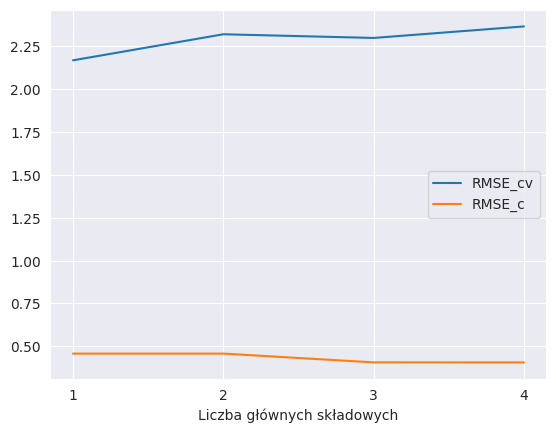

In [23]:
principal_component_plot(4)

Po analizie powyższego wykresu uważam, że istotną liczbą głównych składowych dla późniejszego zastosowania modelu jest 1. Moja opinia wynika ze względu na najniższą wartość $RMSE_{cv}$, czyli najstabilniejszy model oraz nieróżniącą się dużo wartością $RMSE_c$, czyli relatywnie dobrze przewidujący model dla danych kalibracyjnych.

In [24]:
pca_model = PCA(n_components=1)

PC = pl.DataFrame(
    pca_model.fit_transform(standarized_matrix),
    schema=[f"PC{i+1}" for i in range(pca_model.n_components_)],
)

X_training, X_validation, Y_training, Y_validation = train_test_split(
    PC, Y_obs, test_size=0.33, random_state=42
)

significant_model = LinearRegression().fit(X_training, Y_training)

$R^2$

In [25]:
R2(
    significant_model.predict(X_training).flatten(),
    Y_training
)

0.8404310408845637

$RMSE_c$

In [26]:
RMSE(
    significant_model.predict(X_training).flatten(),
    Y_training
)

0.45763062385975334

$Q^2_{ext}$

In [27]:
Q2(
    significant_model.predict(X_validation).flatten(),
    Y_validation
)

0.710993253537392

$RMSE_{ext}$

In [28]:
RMSE(
    significant_model.predict(X_validation).flatten(),
    Y_validation
)

0.4571195686738966

Otrzymany model wykorzystujący 1 główną składową daje umiarkowanie dobre wyniki. Dzieje się tak mimo tego, że z macierzy korelacji nie wynika, aby była potrzeba przeprowadzenia analizy metodą PCR a raczej metodą MLR.